In [1]:
import pandas as pd
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [2]:
#here the i is for the period we want 
#note that we only have period 1 to 4 in our bucket because that is all we generated with our python script 
i = 1
input_file = f"s3://mlops-project-dataset-deen/paris-housing-dataset/ParisHousing_period_{i:02d}.parquet"


In [3]:
df = pd.read_parquet(input_file)

In [4]:
#we check the first few rows of the model 
df.head()

,index,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category
0,6681,58413,43,1,1,27,19305,3,10,1990,1,1,6367,6234,601,1,3,5852813.0,Luxury
1,7424,75898,97,0,1,6,33301,2,10,1990,1,1,6591,6169,411,0,8,7592058.0,Basic
2,9374,67417,68,0,0,67,3056,9,2,1990,1,0,1335,2071,815,1,8,6743688.0,Basic
3,4427,99291,89,0,0,40,38298,3,10,1990,1,1,4592,8562,369,1,1,9933729.0,Basic
4,5267,63720,18,0,1,59,12560,9,1,1990,0,1,279,5973,542,1,2,6380496.0,Basic


### Here we do some exploratory data analysis 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2500 non-null   int64  
 1   squareMeters       2500 non-null   int64  
 2   numberOfRooms      2500 non-null   int64  
 3   hasYard            2500 non-null   int64  
 4   hasPool            2500 non-null   int64  
 5   floors             2500 non-null   int64  
 6   cityCode           2500 non-null   int64  
 7   cityPartRange      2500 non-null   int64  
 8   numPrevOwners      2500 non-null   int64  
 9   made               2500 non-null   int64  
 10  isNewBuilt         2500 non-null   int64  
 11  hasStormProtector  2500 non-null   int64  
 12  basement           2500 non-null   int64  
 13  attic              2500 non-null   int64  
 14  garage             2500 non-null   int64  
 15  hasStorageRoom     2500 non-null   int64  
 16  hasGuestRoom       2500 

In [6]:
#we check the sim of the missing values 
#we have no missing values 
df.isnull().sum()

index                0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
category             0
dtype: int64

In [7]:
#we do some descriptive statistics
#
df.describe()

,index,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03
mean,4960.34560,49717.466400,50.375600,0.505200,0.503600,50.197600,49519.428800,5.510400,5.510800,1993.377600,0.4996,0.506800,5086.601600,4944.752400,548.526000,0.514400,5.029600,4.978221e+06
std,2881.76989,28674.269798,28.918317,0.500073,0.500087,29.162735,29139.542249,2.873951,2.857192,2.253231,0.5001,0.500054,2902.081264,2898.927461,262.154159,0.499893,3.212235,2.867469e+06
min,4.00000,89.000000,1.000000,0.000000,0.000000,1.000000,24.000000,1.000000,1.000000,1990.000000,0.0000,0.000000,0.000000,1.000000,100.000000,0.000000,0.000000,1.031350e+04
25%,2563.75000,25572.500000,25.000000,0.000000,0.000000,25.000000,23351.000000,3.000000,3.000000,1991.000000,0.0000,0.000000,2642.250000,2401.750000,322.750000,0.000000,2.000000,2.563086e+06
50%,4849.00000,49356.500000,50.000000,1.000000,1.000000,50.000000,50565.000000,5.000000,6.000000,1993.000000,0.0000,1.000000,5215.500000,4914.500000,552.000000,1.000000,5.000000,4.938377e+06
75%,7429.00000,74705.250000,75.000000,1.000000,1.000000,76.000000,75339.750000,8.000000,8.000000,1995.000000,1.0000,1.000000,7613.500000,7462.000000,770.250000,1.000000,8.000000,7.476535e+06
max,9999.00000,99932.000000,100.000000,1.000000,1.000000,100.000000,99921.000000,10.000000,10.000000,1997.000000,1.0000,1.000000,9997.000000,9984.000000,1000.000000,1.000000,10.000000,1.000294e+07


In [8]:
#checks the 95 98 99 percentiles
df.price.describe(percentiles=[0.95, 0.98, 0.99])

count    2.500000e+03
mean     4.978221e+06
std      2.867469e+06
min      1.031350e+04
50%      4.938377e+06
95%      9.488480e+06
98%      9.817505e+06
99%      9.907187e+06
max      1.000294e+07
Name: price, dtype: float64

/home/deen/anaconda3/envs/project/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

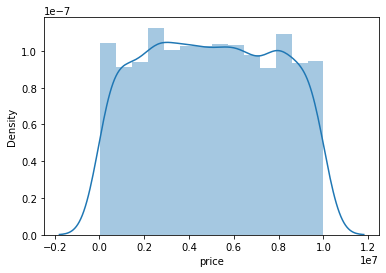

In [9]:
#we check the distribution of the prices 
sns.distplot(df.price)

<AxesSubplot:ylabel='price'>

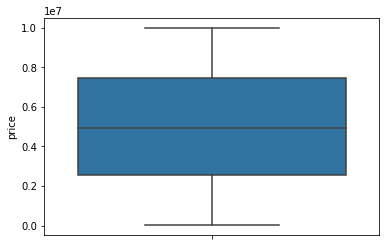

In [10]:
#seems there are no outliers
sns.boxplot(y=df.price)

In [11]:
df_rooms = df.groupby('numberOfRooms').category.value_counts()

In [12]:
#here we look at the difference between the basic and luxury appartments when it comes to qty of rooms
with pd.option_context("display.max_rows", None):
    display(df_rooms)

numberOfRooms  category
1              Basic       21
               Luxury       1
2              Basic       19
               Luxury       2
3              Basic       28
               Luxury       6
4              Basic       26
               Luxury       3
5              Basic       19
               Luxury       4
6              Basic       17
               Luxury       3
7              Basic       19
               Luxury       4
8              Basic       25
               Luxury       4
9              Basic       16
               Luxury       3
10             Basic       26
               Luxury       2
11             Basic       21
               Luxury       3
12             Basic       17
               Luxury       4
13             Basic       19
               Luxury       3
14             Basic       22
               Luxury       4
15             Basic       18
               Luxury       8
16             Basic       19
               Luxury       3
17             B

In [13]:
#here we drop the category column
df['category'] = pd.factorize(df['category'])[0] + 1
dataset = df

<AxesSubplot:>

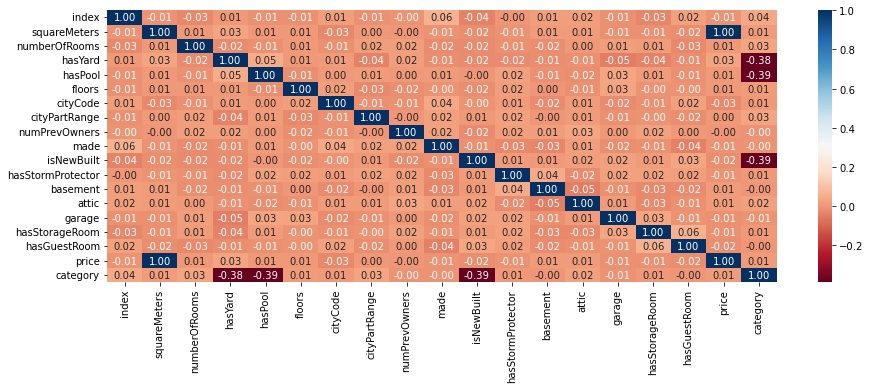

In [14]:
#we create a heatmap to see which categories influence the price of house
corr = dataset.corr()
#we choose the size of the figure 
fig, ax = plt.subplots(figsize=(15, 5))
#choosing the color of the heatmap with annotation
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")


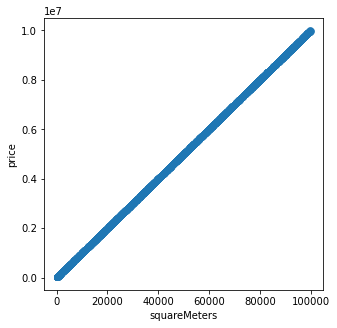

In [15]:
#we plot the squaremeters and the price 
fig, ax1 = plt.subplots(figsize=(5, 5))
sns.regplot(x="squareMeters", y="price", data=df);

### from the correlation heatmap we can see that the square meter has a very strong correclation with the price of the houses

In [16]:
df.dtypes

index                  int64
squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
category               int64
dtype: object

In [17]:
#we try different models 

In [18]:
def read_dataframe(filename):
    #we read the file
    if filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    #we are using the squaremeter as feature for the model
    return  df    

In [19]:
#we you period 1 as our training dataset 
i = 1
input_file = f"s3://mlops-project-dataset-deen/paris-housing-dataset/ParisHousing_period_{i:02d}.parquet"
df_train = read_dataframe(input_file)

In [20]:
#we use period 2 as our validation dataset
i = 2
file = f"s3://mlops-project-dataset-deen/paris-housing-dataset/ParisHousing_period_{i:02d}.parquet"
df_val = read_dataframe(file)

In [21]:
#we choose the feature here 
categorical = ['squareMeters']
df_train_data = df_train[categorical]
df_val_data = df_val[categorical]

In [22]:
#we convert the columns to a dictionary
train_dicts = df_train_data[categorical].to_dict(orient='records')
val_dicts = df_train_data[categorical].to_dict(orient='records')

In [23]:
#dictionary to vector converter
dv = DictVectorizer()

#dictionary to vector conversion, here we use fit because its for training
X_train = dv.fit_transform(train_dicts)

#here we use transorm because its for validation
X_val = dv.transform(val_dicts)

In [24]:
#for this model, our interest is the price of the house 
target = 'price'
y_train = df_train[target].values
y_val = df_val[target].values

In [25]:
#to verify the feature used by the vectorizer 
dv.feature_names_

['squareMeters']

In [26]:
#we check the shape of the matrix
#X_train.shape

In [27]:
#we store the linear regression as regressor_linear
regressor_linear = LinearRegression()
#we fit the model
regressor_linear.fit(X_train, y_train)

LinearRegression()

In [28]:
#here we try to predict the values of y_val which is the house price
#using the real x_train which is the squaremeters 
y_pred = regressor_linear.predict(X_val)

In [29]:
#we compute the mean squared error between the predicted and the real values 
mean_squared_error(y_val, y_pred, squared=False)

4137268.6811244194

/home/deen/anaconda3/envs/project/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/deen/anaconda3/envs/project/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


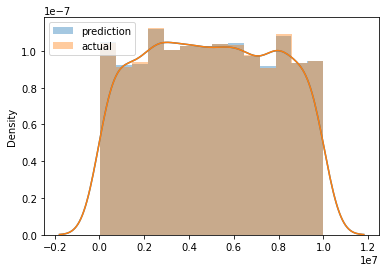

In [30]:
#we get the graphical view of the house we predicted and compare it with the actual house price 
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [31]:
#we create a folder called models
#!mkdir models

In [32]:
#Using lasso regressor
regressor_lasso = Lasso(alpha=0.012)
#we fit the model
regressor_lasso.fit(X_train, y_train)
y_pred_1 = regressor_lasso.predict(X_train)


mean_squared_error(y_val, y_pred_1, squared=False)

4137268.681124121

In [33]:
#Using ridge regressor
regressor_Ridge = Ridge(alpha=0.012)
#we fit the model
regressor_Ridge.fit(X_train, y_train)
y_pred_2 = regressor_Ridge.predict(X_train)

mean_squared_error(y_val, y_pred_2, squared=False)


4137268.6811244055